In [0]:
import numpy as np
import pandas as pd
import matplotlib #
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn #
import spark
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import KFold
import mlflow

In [0]:
#pip install spark

Python interpreter will be restarted.
  Using cached spark-0.2.1-py3-none-any.whl
Python interpreter will be restarted.


In [0]:
#!pip install mlflow==1.20.2

  Using cached mlflow-1.20.2-py3-none-any.whl (14.6 MB)
  Using cached prometheus_flask_exporter-0.23.0-py3-none-any.whl (18 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)
  Using cached alembic-1.4.1-py2.py3-none-any.whl
  Using cached sqlparse-0.4.4-py3-none-any.whl (41 kB)
  Using cached querystring_parser-1.2.4-py2.py3-none-any.whl (7.9 kB)
  Using cached flask-3.0.0-py3-none-any.whl (99 kB)
  Using cached SQLAlchemy-2.0.25-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached gunicorn-21.2.0-py3-none-any.whl (80 kB)
  Using cached importlib_metadata-7.0.1-py3-none-any.whl (23 kB)
  Using cached PyYAML-6.0.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (738 kB)
  Using cached GitPython-3.1.40-py3-none-any.whl (190 kB)
  Using cached databricks_cli-0.18.0-py2.py3-none-any.whl (150 kB)
  Using cached docker-7.0.0-py3-none-any.whl (147 kB)
  Using cached Mako-1.3.0-py3-none-any.whl (78 kB)
  Using cached python_editor-1.0.4-py3-non

In [0]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("mlflow").getOrCreate()

# File location and type
file_location = "/FileStore/tables/creditcard.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
dataframe = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

# Convert Spark DataFrame to Pandas DataFrame
df = dataframe.toPandas()


In [0]:
#df = df.drop("Time", axis=1) # cette colonne n'apporte rien à notre analyse 
df.head()
  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Out[5]: <AxesSubplot:xlabel='Class', ylabel='count'>

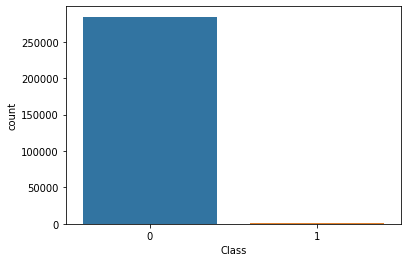

In [0]:
sns.countplot(x='Class',data=df)

In [0]:
normal = df[df.Class == 0].sample(frac=0.5,random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

In [0]:
print(f"Normal: {normal.shape}")
print(f"Anomaly: {anomaly.shape}")

Normal: (142158, 31)
Anomaly: (492, 31)


In [0]:
normal_train, normal_test = train_test_split(normal,test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)
normal_train, normal_validate = train_test_split(normal_train,test_size = 0.25, random_state = 2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size = 0.25, random_state = 2020)

In [0]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate, anomaly_validate))

In [0]:
y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

In [0]:
x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)

In [0]:
print("Training sets:\nx_train: {} \ny_train:{}".format(x_train.shape, y_train.shape))
print("\nTesting sets:\nx_test: {} \ny_test:{}".format(x_test.shape, y_test.shape))
print("\nValidation sets:\nx_validate: {} \ny_validate: {}".format(x_validate.shape, y_validate.shape))

Training sets:
x_train: (85588, 30) 
y_train:(85588,)

Testing sets:
x_test: (28531, 30) 
y_test:(28531,)

Validation sets:
x_validate: (28531, 30) 
y_validate: (28531,)


In [0]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))

Out[13]: StandardScaler()

In [0]:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

In [0]:
def train(sk_model, x_train, y_train):
    sk_model = sk_model.fit(x_train, y_train)
    train_acc = sk_model.score(x_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Accuracy: {train_acc:.3%}")

In [0]:
def evaluate(sk_model, x_test, y_test):
    eval_acc = sk_model.score(x_test, y_test)
    preds = sk_model.predict(x_test)
    auc_score = roc_auc_score(y_test, preds)
    mlflow.log_metric("eval_acc", eval_acc) # nous avons fait la même chose pour l'accuracy de test (evaluation)
    mlflow.log_metric("auc_score", auc_score)# aussi pour l'AUC score 
    print(f"Auc Score: {auc_score:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")
    roc_plot = RocCurveDisplay.from_estimator(sk_model, x_test, y_test,name='Scikit-learn ROC Curve')
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()
    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")
    # nous avons dit à MLflow de sauvegarder ces deux figure afin de les consulter à chaque 
    # exécution d'une façon organisée comme nous allons le voir plus loin dans cet atelier  
    mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

In [0]:
#to configure your DataBricks CLI
token = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiToken().get()
dbutils.fs.put("file:///root/.databrickscfg","[DEFAULT]\nhost=https://community.cloud.databricks.com\ntoken ="+token,overwrite=True)

Wrote 97 bytes.
Out[17]: True

/databricks/python/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Train Accuracy: 99.896%
Auc Score: 85.343%
Eval Accuracy: 99.877%


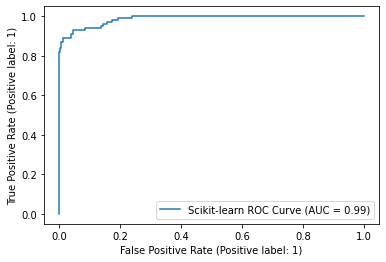

Model run:  117ae14dc6924b55a32866906c865a9b


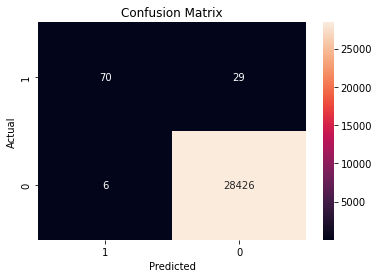

In [0]:
from sklearn.metrics import RocCurveDisplay
sk_model = LogisticRegression(random_state=None,max_iter=10, solver='newton-cg')
mlflow.set_experiment("/Users/tadlaouisalma25@gmail.com/scikit_learn_experiment1")
with mlflow.start_run():
    train(sk_model, x_train, y_train)
    evaluate(sk_model, x_test, y_test)
    mlflow.sklearn.log_model(sk_model, "log_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

In [0]:

# define evaluation

# define search space
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
# summarize result
#print('Best Score: %s' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

model = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)
mlflow.set_experiment("/Users/tadlaouisalma25@gmail.com/scikit_learn_experiment1")
with mlflow.start_run():
    search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
    sk_model = search.fit(x_train, y_train)
    train(sk_model, x_train, y_train)
    evaluate(sk_model, x_test, y_test)
    mlflow.sklearn.log_model(sk_model, "log_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

In [0]:
all_runs = mlflow.search_runs(max_results=10)  # Note : This is pandas dataframe
display(all_runs)

run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.auc_score,metrics.eval_acc,metrics.train_acc,tags.mlflow.databricks.cluster.id,tags.mlflow.databricks.notebookRevisionID,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.databricks.notebookPath,tags.mlflow.runName,tags.mlflow.databricks.notebookID,tags.mlflow.source.type,tags.mlflow.databricks.cluster.info,tags.mlflow.databricks.notebook.commandID,tags.mlflow.databricks.webappURL,tags.mlflow.databricks.cluster.libraries,tags.mlflow.log-model.history
c71dc17f3a794e24811cdadbeb15aee8,723360604805015,FAILED,dbfs:/databricks/mlflow-tracking/723360604805015/c71dc17f3a794e24811cdadbeb15aee8/artifacts,2024-01-07T19:01:19.961+0000,2024-01-07T19:25:50.741+0000,null,null,null,0107-182129-w27ns1ll,1704655551182,tadlaouisalma25@gmail.com,/Users/tadlaouisalma25@gmail.com/5. MLflow-DataBricks (2),/Users/tadlaouisalma25@gmail.com/5. MLflow-DataBricks (2),handsome-horse-87,723360604804990,NOTEBOOK,"{""cluster_name"":""cluster"",""spark_version"":""12.2.x-scala2.12"",""node_type_id"":""dev-tier-node"",""driver_node_type_id"":""dev-tier-node"",""autotermination_minutes"":120,""disk_spec"":{""disk_count"":0},""num_workers"":0}",3126197929566587417_7520891962109704890_c451860a00a146feabacb36031aa62b7,https://community.cloud.databricks.com,"{""installable"":[],""redacted"":[]}",null
117ae14dc6924b55a32866906c865a9b,723360604805015,FINISHED,dbfs:/databricks/mlflow-tracking/723360604805015/117ae14dc6924b55a32866906c865a9b/artifacts,2024-01-07T19:00:51.353+0000,2024-01-07T19:00:59.906+0000,0.8534298386225793,0.9987732641687989,0.9989601345983081,0107-182129-w27ns1ll,1704654060492,tadlaouisalma25@gmail.com,/Users/tadlaouisalma25@gmail.com/5. MLflow-DataBricks (2),/Users/tadlaouisalma25@gmail.com/5. MLflow-DataBricks (2),overjoyed-slug-632,723360604804990,NOTEBOOK,"{""cluster_name"":""cluster"",""spark_version"":""12.2.x-scala2.12"",""node_type_id"":""dev-tier-node"",""driver_node_type_id"":""dev-tier-node"",""autotermination_minutes"":120,""disk_spec"":{""disk_count"":0},""num_workers"":0}",3126197929566587417_7910413006036048779_6e48b40dc88347a6b66584cb3ddba764,https://community.cloud.databricks.com,"{""installable"":[],""redacted"":[]}","[{""artifact_path"":""log_reg_model"",""flavors"":{""python_function"":{""model_path"":""model.pkl"",""loader_module"":""mlflow.sklearn"",""python_version"":""3.9.5"",""env"":""conda.yaml""},""sklearn"":{""pickled_model"":""model.pkl"",""sklearn_version"":""1.0.2"",""serialization_format"":""cloudpickle""}},""run_id"":""117ae14dc6924b55a32866906c865a9b"",""utc_time_created"":""2024-01-07 19:00:55.845503"",""databricks_runtime"":""12.2.x-scala2.12""}]"
89c0d06b7276447f9625d4d6575ca9c0,723360604805015,FAILED,dbfs:/databricks/mlflow-tracking/723360604805015/89c0d06b7276447f9625d4d6575ca9c0/artifacts,2024-01-07T18:40:38.780+0000,2024-01-07T18:58:38.064+0000,null,null,null,0107-182129-w27ns1ll,1704653918738,tadlaouisalma25@gmail.com,/Users/tadlaouisalma25@gmail.com/5. MLflow-DataBricks (2),/Users/tadlaouisalma25@gmail.com/5. MLflow-DataBricks (2),indecisive-loon-519,723360604804990,NOTEBOOK,"{""cluster_name"":""cluster"",""spark_version"":""12.2.x-scala2.12"",""node_type_id"":""dev-tier-node"",""driver_node_type_id"":""dev-tier-node"",""autotermination_minutes"":120,""disk_spec"":{""disk_count"":0},""num_workers"":0}",5816342511405739036_7881408435220551452_bdc5add8a1f94981a3580ea99b269db5,https://community.cloud.databricks.com,"{""installable"":[],""redacted"":[]}",null
61756a806bb14e79a4d44b3fce5e393a,723360604805015,FINISHED,dbfs:/databricks/mlflow-tracking/723360604805015/61756a806bb14e79a4d44b3fce5e393a/artifacts,2024-01-07T18:40:11.289+0000,2024-01-07T18:40:20.391+0000,0.8534122528037835,0.9987382145736217,0.9989250829555545,0107-182129-w27ns1ll,1704652820768,tadlaouisalma25@gmail.com,/Users/tadlaouisalma25@gmail.com/5. MLflow-DataBricks (2),/Users/tadlaouisalma25@gmail.com/5. MLflow-DataBricks (2),burly-stag-261,723360604804990,NOTEBOOK,"{""c

TAF: 

1. réexécutez la cellule 18 en utilisant d'autres modèle ML de SKlearn 
2. comparez vos résultats en utilisant l'outil de comparaison de MLFlow

Train Accuracy: 99.944%
Auc Score: 83.833%
Eval Accuracy: 99.877%


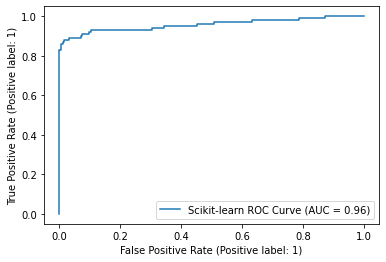

Model run:  d22035bffbee487ababaf0c47cb91034


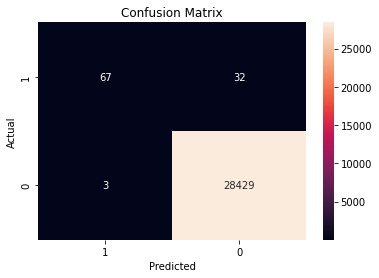

In [0]:
from sklearn.svm import SVC
svm_model = SVC(random_state=None)

# Set up your MLflow experiment
mlflow.set_experiment("/Users/tadlaouisalma25@gmail.com/scikit_learn_experiment1")

# Start an MLflow run
with mlflow.start_run():
    train(svm_model, x_train, y_train)
    evaluate(svm_model, x_test, y_test)
    print("Model run: ", mlflow.active_run().info.run_uuid)

mlflow.end_run()

Train Accuracy: 100.000%
Auc Score: 88.884%
Eval Accuracy: 99.912%


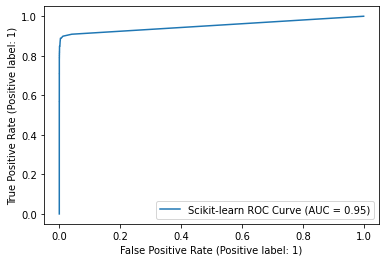

Model run:  96eb18e77828403fbccd229cf5d138b1


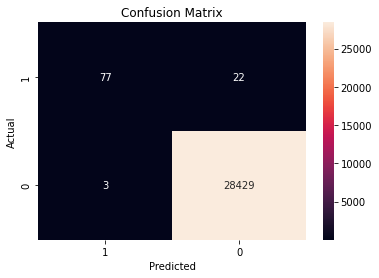

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=None)

mlflow.set_experiment("/Users/tadlaouisalma25@gmail.com/scikit_learn_experiment1")
with mlflow.start_run():
    train(rf_model, x_train, y_train)
    evaluate(rf_model, x_test, y_test)
    mlflow.sklearn.log_model(rf_model, "random_forest_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)

# End the MLflow run
mlflow.end_run()